In [1]:
# A notebook for peristaltic last layer tuning (PeLaTun) - training the last transformer block (& onwards) of llama2-7B, with context length 4096, in 16-bit, with 8GB VRAM.

# --- Intuition behind why, and how it works
# Named peristaltic because we pass the entire dataset through the model progressively through small sections at a time (in this case one transformer block at a time).
# This is kind of the opposite of the standard practice of passing small sections of the dataset through all of the layers of the model at a time.
# This swaps high VRAM requirements for MUCH slower speed and HIGH storage requirements.

# The idea is basically that you can get decent results by just finetuning the last few layers of a language model (in our case the lm_head, norm, and the last transformer block),
# so we can take advantage of this to reduce VRAM requirements by pre-processing the dataset through the lower layers of the transformer until we have
# a dataset consisting of the activations before the final few layers we are going to train, and the ground truth tokens to predict.

# We can further reduce VRAM requirements for the preprocessing stage by only loading in a single transformer layer at a time - what I'm calling 'peristaltic inference'
# we first take the original text dataset, tokenize it, get the embeddings, then save the embeddings to disk.
# We then load the first transformer block, pass the embedded dataset through it, and overwrite the embeddings with the output activations/hidden states, and then finally unload that transformer block.
# We then load the next transformer block, pass the previous activations through it and overwwrite them again.
# We repeat this process until we have the activations that are to be inputted to the layers we are going to train.
# In this notebook we only ever load 1 transformer block (+ lm_head and norm) at a time and use batch size 1 for inference and training, since this is the only way to make it fit in 8GB VRAM,
# but with more VRAM you could load a few layers at a time and increase the batch size to speed it up a lot, as long as your not loading all the layers you will be using less VRAM than standard fine tuning

# For finetuning, you then load just the final transformer layer(s) you want to train, load the precalculated activations, load the labels, and then finetune in the standard way,
# just passing the activations as input rather than tokens.

# --- Future
# For further VRAM reduction, combining this with QLoRa would be great.
# The hope is to be able to finetune the last few layers of a 70B LLM on 8GB VRAM using QLoRa and probably some low-VRAM optimizer.

# --- Issues
# The main issue with this is I/O bandwidth and storage space - peristaltic inference means you load a batch of hidden states,
# do inference through a single transformer block, then overwrite them on the disk.
# It is much faster to pass a batch of hidden states through a transformer block than to write it to disk. This means that after each batch,
# you are always waiting for the write operation to finish before you start the next one,
# otherwise you are dumping them into VRAM/RAM faster than they can be removed and you crash.
# This means dataset paristalsis is very, very, very slow - to get the activations from layer 31 out of 32 in llama-7B for 300 text samples from open ORCA (context length below 1000, which affects disk writing speed), it takes over an hour

# It also takes up a lot of space: 300 samples of ~1000 tokens per sample becomes 3GB for en embeddings size of 4096. A txt file of 1GB will likely turn into over 1TB.
# This is even with optimizations such as only storing activations from the most recent layer, and not storing activations which are to be padded.

# --- Advantages
# The advantage is that it makes finetuning large language models possible on some hardware where it was not before,
# and can remove the need for PEFT in exchange for effectively freezing earlier layers.
# Another advantage is now that our dataset is pre-processed like this, it makes training much faster - you are only ever passing activations through the last layer,
# rather than the ones leading up to it. This makes iterations of training runs much faster after the initial dataset peristalsis.

In [ ]:
# FUTURE: to train the whole model, take ideas from gradient checkpointing! However, unlike activation forward passing, only the last gradient when training is accurate to the new model - we cant just store gradients during training and backprop. we need to re-calculate the gradient for each sample after training.
# the amount of disk space, training time and inference time this would take makes it imo not worth it.
# this is just a fun little project to try out an idea I had and get some practice.

In [5]:
# DOWNLOAD MODEL - causes crash afterward - not enough VRAM in T4 instance to actually load it. After that, just run the cells after this one
# or, interrupt this cell's execution just after the download finishes, before its loaded
if True:
    access_token_read = 'YOUR LLAMA-2 PERMISSED AUTH HUGGINGFACE TOKEN HERE'

    !pip install git+https://github.com/huggingface/transformers #accelerate deepspeed
    from huggingface_hub import login
    login(token = access_token_read)

    from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
    import torch
    model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf", cache_dir="/llama2-7b", torch_dtype=torch.float16)

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-zrtc3igk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-zrtc3igk
  Resolved https://github.com/huggingface/transformers to commit 05de038f3d249ce96740885f85fd8d0aa00c29bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.34.0.dev0-py3-none-any.whl size=7659564 sha256=efd88a33d33320b232f3d293f749429dd247f3775431b1c0143253e725a857c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-_dv9lv4l/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully

KeyboardInterrupt: ignored

In [6]:
batch_size = 1 # for peristaltic inference and training
num_layers = 32 # the number of transformer blocks in the LM
blocks_to_train = 1 # how many transformer blocks at the end of the model to train
num_samples = 300

In [7]:
# INITIALIZE SINGLE TRANSFORMER LAYER
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, AutoTokenizer
from pathlib import Path
import transformers, torch
from torch import nn


model_folder =  "/llama2-7b/models--meta-llama--Llama-2-7b-hf/snapshots/6fdf2e60f86ff2481f2241aaee459f85b5b0bbb9/"
model_paths = sorted(list(Path(model_folder).glob('*-00002*.safetensors')))

llamaconfig = transformers.models.llama.modeling_llama.LlamaModel.config_class.from_pretrained(
                model_folder+'config.json',
                cache_dir="",
                return_unused_kwargs=False,
                force_download=False,
                resume_download=False,
                proxies='',
                local_files_only=True,
                token="",
                revision="",
                subfolder="",
                _from_auto=False,
                _from_pipeline=False,)


embed_tokens = nn.Embedding(llamaconfig.vocab_size, llamaconfig.hidden_size, llamaconfig.pad_token_id).to(torch.float16).cuda()
transfo_layer = transformers.models.llama.modeling_llama.LlamaDecoderLayer(llamaconfig).to(torch.float16).cuda()
norm = transformers.models.llama.modeling_llama.LlamaRMSNorm(llamaconfig.hidden_size).half().cuda()
lm_head = nn.Linear(llamaconfig.hidden_size, llamaconfig.vocab_size, bias=False).half().cuda()

In [8]:
# Load pretrained llama 2 weights
from transformers.utils.hub import get_checkpoint_shard_files

resolved_archive_file, sharded_metadata = get_checkpoint_shard_files(
                model_folder,
                model_folder+'model.safetensors.index.json',
                cache_dir="",
                force_download=False,
                proxies=None,
                resume_download=False,
                local_files_only=True,
                token=None,
                user_agent=None,
                revision=None,
                subfolder="",
                _commit_hash=False)


def load_transflayer(layer_index): # this could be optimized. only need to load lm_head, norm, and embeddings once. Dont need to load the state dict of boths .safetensors and then copy over the relevant once, just find which sfetensor contains the parameters we need and load that one.
    for shardfile in resolved_archive_file:
        state_dict = transformers.modeling_utils.load_state_dict(shardfile)
        prefix = "model.layers." + str(layer_index)
        with torch.no_grad():

          # --- LOAD word embeddings
          if "model.embed_tokens.weight" in state_dict.keys():
              embed_tokens.weight.data.copy_(state_dict["model.embed_tokens.weight"])

          # --- LOAD transforer block
          layer_names = [
              'input_layernorm', 'mlp.down_proj', 'mlp.gate_proj', 'mlp.up_proj',
              'post_attention_layernorm', 'self_attn.k_proj', 'self_attn.o_proj',
              'self_attn.q_proj', 'self_attn.rotary_emb.inv_freq', 'self_attn.v_proj']
          for layer_name in layer_names:
              if prefix+'.'+layer_name+'.weight' in state_dict.keys():
                  exec(f"transfo_layer.{layer_name}.weight[:] = state_dict[prefix + '.{layer_name}.weight'][:]")

          # --- LOAD post-transformer norm
          if "model.norm.weight" in state_dict.keys():
              norm.weight[:] = state_dict["model.norm.weight"]

          # --- LOAD lm_head
          if "lm_head.weight" in state_dict.keys():
              lm_head.weight[:] = state_dict["lm_head.weight"]

In [9]:
# Load Open Orca dataset

from torch.utils.data import Dataset, DataLoader
from huggingface_hub import hf_hub_download
import pandas as pd
import pyarrow.parquet as pq


# Download the parquet file
hf_hub_download(repo_id="Open-Orca/OpenOrca", filename="1M-GPT4-Augmented.parquet", repo_type="dataset")
# Load parquet file into a DataFrame
df = pd.read_parquet("/root/.cache/huggingface/hub/datasets--Open-Orca--OpenOrca/snapshots/c115cf330b218dfaa81a182de3267978ddc41f05/1M-GPT4-Augmented.parquet")

# dataloader for Open ORCA
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        print("NUM DOCUMENTS",self.texts.shape[0])
        self.tokenizer = tokenizer

    def __len__(self):
        return self.texts.shape[0]

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]['system_prompt'] + '\n\n<{USER MESSAGE}>: ' + self.texts.iloc[idx]['question'] + '\n\n<{ASSISTANT RESPONSE}>: ' + self.texts.iloc[idx]['response']
        encoded_text = self.tokenizer.encode_plus(
            text,
            padding="max_length",
            truncation=True,
            max_length=4096,  # Specify your desired maximum sequence length
            return_tensors="pt")

        input_ids = encoded_text["input_ids"]
        input_ids[encoded_text["attention_mask"]==0] = pad_token_idx
        return input_ids.squeeze(0).cuda()

# initialize tokenizer. create custom padding token since llama doesnt have one. This allows us to identify padded tokens later and manipulate values in the embeddings/activations so we can track which items need to be padded without taking up extra space, especially when saving/loading hidden states
pad_token_idx = 40000
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
tokenizer.pad_token = pad_token_idx

# Use the 'texts' list as input to the TextDataset
txt = TextDataset(df, tokenizer)

NUM DOCUMENTS 994896


In [10]:
# FUNCTIONS, DATASET LOADER FOR PERISTALTIC DATASET INFERENCE

import threading
import queue
import pickle
import os
import torch.multiprocessing





# load saved activations from disk
class BatchedHiddenStatesDataset(Dataset):
    def __init__(self, folder_path, layer, matched_to_activations=False):
        self.layer = layer
        self.file_paths = []
        #print("searching for:", f"layer{str(layer-1).zfill(3)}")

        for filename in os.listdir(folder_path):
            if not filename.endswith(".pt"):
                continue

            # only get files from previous layer
            if layer==0 and "embed" in filename:
                self.file_paths.append(os.path.join(folder_path, filename))

            elif f"layer{str(layer-1).zfill(3)}" in filename:
                self.file_paths.append(os.path.join(folder_path, filename))
        self.file_paths = sorted(self.file_paths)


    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        if file_path is None:
            return None
        with open(file_path,'rb') as file:
            output = pickle.load(file)
            output = convert_to_padded_tensor(output)
            # fill ragged tensor to full tensor so context size = 4096
            assert output.shape[0] == batch_size
            # Infer attention mask from the loaded output

        # delete previous peristaltic data
        if self.layer < num_layers-blocks_to_train:
          #print('deleting',file_path)
          os.remove(file_path)

        filename = file_path.split('/')[-1].split('_')[1]
        return output.to(torch.bfloat16), filename






# functions for saving/loading activations and dealing with varying sized sequences in a sotrage efficient manner

def save_batch_outputs(batch_outputs, output_path):
    with open(output_path, 'wb') as file:
        pickle.dump(batch_outputs, file)
        #batch_outputs.save(output_path)
        del batch_outputs

def convert_to_ragged_tensor(tensor): # we dont want to save the full [bsz, seq_len, hidden_size] tensor for each sample - we want to remove values which are padded, saving a lot of space. We separate the tensor into a list by sample index, and cut each tensor to its non-padded size. This is what we save. its called a ragged tensor because I was confused and the name stuck.
    ragged_tensor = list(tensor.tensor_split(batch_size))
    for i,seq in enumerate(ragged_tensor):
        seq=seq.squeeze(0)
        pad_indices = torch.where(seq == pad_token_idx)[0]
        if pad_indices.numel() > 0:
            N = pad_indices.min().item()
        else:
            N = 0
        ragged_tensor[i] = seq[0:N].to(torch.float16).cpu()
    return ragged_tensor

def convert_to_padded_tensor(ragged_tensor):
    padded_values = torch.full((batch_size,4096,4096), pad_token_idx, dtype=torch.float16, device='cuda')
    for b,seq in enumerate(ragged_tensor):
        padded_values[b,0:len(seq)] = seq
    return padded_values





# function to take in a parquet dataset DataFrame, an output directory, and get the token embeddings for tha dataset and save them
def dataset_transform_embed(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    input_dataset = txt
    input_dataloader = DataLoader(input_dataset, batch_size=batch_size, shuffle=False)
    process = None

    for b, batch_inputs in enumerate(input_dataloader):
        #print(tokenizer.decode(batch_inputs[0]))

        output_path = os.path.join(output_dir, f"output_{str(b).zfill(6)}_embed.pt")
        padding_mask = ~(batch_inputs == pad_token_idx)
        batch_inputs[batch_inputs == pad_token_idx] = 0 # cant embed the special padding token since its not a valid token

        # wait until we saved the last tensor to get new one
        if process is not None:
            process.join()

        # embed
        with torch.no_grad():
            batch_outputs = embed_tokens(batch_inputs)

        mask = padding_mask.unsqueeze(-1).expand_as(batch_outputs)
        print("OUT", batch_outputs.mean(), "sample=",b*batch_size, 'batch=',b, f"output_{str(b).zfill(6)}_embed.pt")
        batch_outputs = batch_outputs.masked_fill_(~mask.bool(), pad_token_idx)
        batch_outputs = convert_to_ragged_tensor(batch_outputs)


        process = torch.multiprocessing.Process(target=save_batch_outputs, args=(batch_outputs, output_path))
        process.start()

        if b+1 == num_samples:
            process.join()     # FOR DEMO PURPOSES, JUST GETTING 1000
            break









# given a transformer layer, a directory of input activations and a directory to,
# this function passes the dataset of input activations through the given transformer layer and outputs to save dir
def dataset_transform_transflayer(input_dir, output_dir, layer):
    os.makedirs(output_dir, exist_ok=True)

    input_dataset = BatchedHiddenStatesDataset(input_dir, layer)
    input_dataloader = DataLoader(input_dataset, batch_size=batch_size, shuffle=False)
    process = None


    for b, (batch_inputs,fileidx) in enumerate(input_dataloader):
        fileidx = fileidx[0]
        output_path = os.path.join(output_dir, f"output_{fileidx}_layer{str(layer).zfill(3)}.pt")
        batch_inputs = batch_inputs.squeeze(0).cuda()
        seq_len = batch_inputs.shape[1]


        # wait until we saved the last tensor to get new one
        if process is not None:
            process.join()

        # transformer layer inference
        with torch.no_grad():
            position_ids = torch.arange(0, seq_len, dtype=torch.long)
            position_ids = position_ids.unsqueeze(0).view(-1, seq_len)
            padding_mask = ~(batch_inputs > 10000).any(dim=2) #pad_token_idx
            attention_mask = transformers.models.llama.modeling_llama.LlamaModel._prepare_decoder_attention_mask(self=None, attention_mask=padding_mask, input_shape=(batch_size, seq_len), inputs_embeds=batch_inputs.half(), past_key_values_length=0)
            batch_inputs[batch_inputs>10000] = 0 # imprecision in float16 means checking for the padding token like this. There shouldnt be anything else of that scale in the activations
            batch_outputs = transfo_layer(batch_inputs.to(torch.float16),
                                          attention_mask=attention_mask,
                                          position_ids=position_ids,
                                          past_key_value=None,
                                          output_attentions=False,
                                          use_cache=False)[0]


        # Mark padding on batch output
        mask = padding_mask.unsqueeze(-1).expand_as(batch_outputs)
        batch_outputs = batch_outputs.masked_fill_(~mask.bool(), pad_token_idx)


        batch_outputs = convert_to_ragged_tensor(batch_outputs)

        process = torch.multiprocessing.Process(target=save_batch_outputs, args=(batch_outputs, output_path))
        process.start()



In [11]:
# set dataset input location and where activations should be saved
tokens_dir = df # the dataframe loaded earlier from the OpenOrca parquet file
activations_dir = "/content/drive/MyDrive/pelatun_ORCA2"

In [12]:
# .txt DATASET -> token embeddings layer -> embeddings dataset folder

!rm -rf /content/drive/MyDrive/pelatun_ORCA2
!mkdir /content/drive/MyDrive/pelatun_ORCA2

load_transflayer(-1) # load embeddings layer
dataset_transform_embed(tokens_dir, activations_dir)

torch.cuda.empty_cache()

mkdir: cannot create directory ‘/content/drive/MyDrive/pelatun_ORCA2’: No such file or directory
OUT tensor(-5.9605e-08, device='cuda:0') sample= 0 batch= 0 output_000000_embed.pt
OUT tensor(-5.9605e-07, device='cuda:0') sample= 1 batch= 1 output_000001_embed.pt
OUT tensor(-8.3447e-07, device='cuda:0') sample= 2 batch= 2 output_000002_embed.pt
OUT tensor(-5.9605e-08, device='cuda:0') sample= 3 batch= 3 output_000003_embed.pt
OUT tensor(-2.8610e-06, device='cuda:0') sample= 4 batch= 4 output_000004_embed.pt
OUT tensor(-1.1921e-07, device='cuda:0') sample= 5 batch= 5 output_000005_embed.pt
OUT tensor(-3.5763e-07, device='cuda:0') sample= 6 batch= 6 output_000006_embed.pt
OUT tensor(-2.0266e-06, device='cuda:0') sample= 7 batch= 7 output_000007_embed.pt
OUT tensor(-3.2187e-06, device='cuda:0') sample= 8 batch= 8 output_000008_embed.pt
OUT tensor(1.8477e-06, device='cuda:0') sample= 9 batch= 9 output_000009_embed.pt
OUT tensor(4.1723e-07, device='cuda:0') sample= 10 batch= 10 output_000010

In [13]:
# embeddings dataset layer n -> peristaltic inference layer n+1 -> embeddings dataset layer n+1

# for transformer layer in model:
for layer in range(0,num_layers-blocks_to_train): # run inference through transfo layers 0,1,2,3,...30

  # get next transformer layer
  load_transflayer(layer)
  transfo_layer = transfo_layer.to(torch.float16)
  print("inferring for layer", layer)
  dataset_transform_transflayer(activations_dir, activations_dir, layer)


inferring for layer 0
inferring for layer 1
inferring for layer 2
inferring for layer 3
inferring for layer 4
inferring for layer 5
inferring for layer 6
inferring for layer 7
inferring for layer 8
inferring for layer 9
inferring for layer 10
inferring for layer 11
inferring for layer 12
inferring for layer 13
inferring for layer 14
inferring for layer 15
inferring for layer 16
inferring for layer 17
inferring for layer 18
inferring for layer 19
inferring for layer 20
inferring for layer 21
inferring for layer 22
inferring for layer 23
inferring for layer 24
inferring for layer 25
inferring for layer 26
inferring for layer 27
inferring for layer 28
inferring for layer 29
inferring for layer 30


In [14]:
torch.cuda.empty_cache()

In [19]:
# FINETUNING THE LAST TRANSFORMER BLOCK

# load activations dataset for input to last layer to tune
hidden_dataloader = DataLoader(BatchedHiddenStatesDataset(activations_dir, 31), batch_size=batch_size, shuffle=False)
# load labels dataset
txt_dataloader = DataLoader(txt, batch_size=batch_size, shuffle=False)


# load final transformer block.
load_transflayer(31)
transfo_layer.eval()
transfo_layer = transfo_layer.to(torch.bfloat16)
norm = norm.to(torch.bfloat16)
lm_head = lm_head.to(torch.bfloat16)

optimizer = torch.optim.Adam(lr=1e-4, params=list(transfo_layer.parameters()) + list(lm_head.parameters()) + list(norm.parameters() )) # takes up 10GB peak during training
#optimizer = torch.optim.SGD(lr=1e-5, params=list(set(transfo_layer.parameters()).union(lm_head.parameters())))


# note that we train with batch_size = 1. If the batch size for inference was set differently to 1 earlier,
# we accumulate the gradients across this many samples (across the samples within each saved file)


global batch_outputs, mhidden_states, hidden_states
losses=[]
for i, ((mhidden_states,fileidx), my) in enumerate(zip(hidden_dataloader, txt_dataloader)):
    #print(tokenizer.decode(my[0]))
    if mhidden_states == None: # in case there is no matching hidden state saved for that txt file
        continue
    mhidden_states=mhidden_states.to(torch.bfloat16).cpu() # save mem
    my[my==pad_token_idx]=-100

    loss=0
    for b in range(batch_size): # when we embed the dataset, we embed in batches. we can embed in larger batches than we can train on, so we separate out the embedding batches into individual samples here.
        hidden_states = mhidden_states[:,b].cuda()
        y = my[b]


        optimizer.zero_grad(set_to_none=True)


        seq_len = 4096
        position_ids = torch.arange(0, seq_len, dtype=torch.long)
        position_ids = position_ids.unsqueeze(0).view(-1, seq_len)
        padding_mask = ~(hidden_states == pad_token_idx).any(dim=2)
        attention_mask = transformers.models.llama.modeling_llama.LlamaModel._prepare_decoder_attention_mask(self=None, attention_mask=padding_mask, input_shape=(1, seq_len), inputs_embeds=hidden_states.half(), past_key_values_length=0)
        hidden_states[hidden_states==pad_token_idx]=0
        hidden_states = hidden_states.to(torch.bfloat16)

        batch_outputs = transfo_layer(hidden_states,
                                      attention_mask=attention_mask,
                                      position_ids=position_ids,
                                      past_key_value=None,
                                      output_attentions=False,
                                      use_cache=False)[0]


        hidden_states = norm(hidden_states).to(torch.bfloat16)
        logits = lm_head(hidden_states).float()



        #loss
        # Shift so that tokens < n predict n
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = y[..., 1:].contiguous()
        loss_fct = torch.nn.CrossEntropyLoss()
        shift_logits = shift_logits.view(-1, llamaconfig.vocab_size)
        shift_labels = shift_labels.view(-1)
        microbatch_loss = loss_fct(shift_logits, shift_labels)
        loss+=microbatch_loss

        del logits, shift_logits, hidden_states, batch_outputs # needed to keep VRAM low
        torch.cuda.empty_cache()
    del mhidden_states
    torch.cuda.empty_cache()

    if (i+1)%batch_size == 0:
        loss = loss/batch_size
        print(i, 'loss:',loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        losses.append(loss.item())
        loss=0




# train model with predict next token loss, to take in activations dataset as input and output label tokens.

0 loss: 2.6539344787597656
1 loss: 3.2336862087249756
2 loss: 3.14791202545166
3 loss: 2.5152227878570557
4 loss: 1.680385947227478
5 loss: 2.6742568016052246
6 loss: 2.3505094051361084
7 loss: 2.317505121231079
8 loss: 2.3936424255371094
9 loss: 2.5580995082855225
10 loss: 1.8501842021942139
11 loss: 1.7071291208267212
12 loss: 2.616697072982788
13 loss: 1.7210774421691895
14 loss: 2.826650619506836
15 loss: 2.2770869731903076
16 loss: 2.4494500160217285
17 loss: 1.5195107460021973
18 loss: 2.1977081298828125
19 loss: 2.4730305671691895
20 loss: 2.1263201236724854
21 loss: 2.6664953231811523
22 loss: 1.5987753868103027
23 loss: 2.1374175548553467
24 loss: 2.369516372680664
25 loss: 2.9688706398010254
26 loss: 1.795179843902588
27 loss: 1.5946440696716309
28 loss: 1.2835139036178589
29 loss: 2.6101596355438232
30 loss: 2.075634717941284
31 loss: 2.6786112785339355
32 loss: 1.380462646484375
33 loss: 1.0014182329177856
34 loss: 2.312438488006592
35 loss: 2.238530158996582
36 loss: 2.475

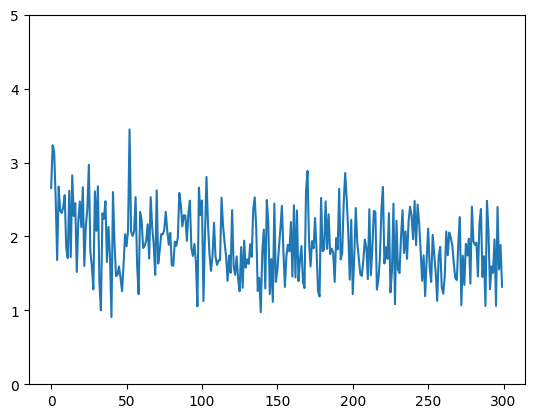

In [20]:
# WITH ADAM
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylim(0, 5)  # Set the y-axis limits
plt.show() # loss go down